# Projeto de IA

In [1]:
from sklearn import metrics
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random as rd

filepath_trettel = '/home/trettel/Documents/projects/DATALAB/datasets/Iris_Data.csv'
filepath_eric = '/home/grayjack/MySources/WorkshopML/data/Iris_Data.csv'
filepath_marcelo = '/home/maru/Projects/ia_docs/Iris_Data.csv'

In [2]:
data = pd.read_csv(filepath_eric)
print(data.describe())

       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


## Criando agrupamento do database

Usando pandas estraimos as informações do database que utilizamos

In [3]:
data.groupby('species').agg(['mean', 'median'])
data.groupby('species').agg([np.mean, np.median])

sepal_length        sepal_width        petal_length         \
                        mean median        mean median         mean median   
species                                                                      
Iris-setosa            5.006    5.0       3.418    3.4        1.464   1.50   
Iris-versicolor        5.936    5.9       2.770    2.8        4.260   4.35   
Iris-virginica         6.588    6.5       2.974    3.0        5.552   5.55   

                petal_width         
                       mean median  
species                             
Iris-setosa           0.244    0.2  
Iris-versicolor       1.326    1.3  
Iris-virginica        2.026    2.0

E então, a partir do database, conseguimos pegar os valores verdadeiros para ser usado como dados de validação mais tarde

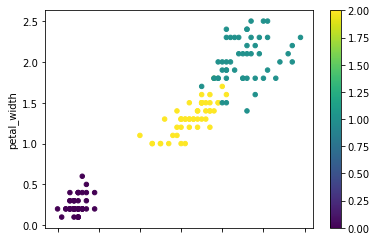

In [4]:
num = {val:i for i,val in enumerate(set(data.species))}
y_true = [num[item] for item in data.species]

data.plot.scatter(x="petal_length", y="petal_width", c=y_true, colormap='viridis')

## Definindo nossa versão do algorítimo

Basicamente o K-Means foi dividido em várias sub-funções com o intuito de facilitar o entendimento total da função.

In [5]:
def plotter(doc, ks, label):
    X,Y = zip(*doc)
    kx,ky = zip(*ks)

    plt.scatter(x=X,y=Y, marker='o', c=label)
    plt.scatter(x=kx, y=ky, marker='x', color='black', s=150)
    
def plotter2(doc):
    X,Y = zip(*doc)
    plt.scatter(x=X,y=Y, marker='o')

Usamos a princípio a distância euclidiana por ser bem fácil de ser implementada em Python

In [6]:
def euclidianDistance(p1, p2):
    return math.sqrt( (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2 )

Criamos uma heurística que segue os seguintes critérios:
 - Se iterador maior que um máximo de iterações, retorna falso;
 - Se a deferença da distância dos centróides for menor ou igual a 0.001, são basicamente iguais então podemos contar como iguais e aumentar o contador de centroides basicmanete imóveis;
 - Se todos os centroides forem praticamente iguais, não teve alteração significativa, retorna falso para quebrar o laço;
 - Quaisquer outros resultados são verdadeiros.

In [7]:
def goCondition(old_centroids, curr_centroids, itter, iter_times):
    if itter >= iter_times: return False    
    
    ctd = 0
    for old_centroid,curr_centroid in zip(old_centroids,curr_centroids):
        if abs(old_centroid[0]-curr_centroid[0]) <= 0.001 and\
           abs(old_centroid[1]-curr_centroid[1]) <= 0.001:
               ctd += 1
    if ctd == len(curr_centroids): return False
    
    return True

In [8]:
def calculateAllDistances(positions, centroids, distFunction=euclidianDistance):
    distances = list()
    for pos in positions:
        list_per_cent = list()
        for index, cent in enumerate(centroids):
            list_per_cent.append(distFunction(cent, pos))

        distances.append(list_per_cent)

    return distances

A função `giveOwnership()` basicamente determina quais pontos pertencem a quais centróides.

É determidado da seguinte forma:
 - Dado uma lista das distância de cada ponto até os centróides, o ponto pertence ao centróide mais próximo dele.
 
Retorna uma lista do mesmo tamanho da quantidade de itens/posições do database.

In [9]:
def giveOwnership(distances):
    label = list()
    for dist in distances:
        min_dist = min(dist)
        label.append(dist.index(min_dist))

    return label

In [10]:
def generateCentroids(list_x, list_y, k):
    (min_x, min_y) = (min(list_x)-(min(list_x)*0.2),\
                      min(list_y)-(min(list_y)*0.2))
    (max_x, max_y) = (max(list_x)+(max(list_x)*0.2),\
                      max(list_y)+(max(list_y)*0.2))

    return [(rd.uniform(min_x, max_x), rd.uniform(min_y, max_y)) for i in range(k)]

`updateCentroids()` é de certa forma peça importante para o desempenho do algorítmo no geral.

Dado que a variável `labels` é uma lista, percorre-la custaria `O(n)`, e se fossemos varrer o vetor para pegar cada índice de `labels` e seus pontos equivalentes, varreríamos esta variável _k_ vezes (quantidade de centróides), ou seja, um total de `O(kn)`.

Mas neste caso, usamos um dicionário, uma estrutura de dados "_hashable_", ou seja, forma uma tabela hash e nesse caso conseguimos acessá-las em tempo `O(1)`.
Então iteramos em cima de posições e rótulos das posições e se o rótulo não tiver no dicionário, adiciona-o e os dá o valor da posição atual, e se existir apenas adicionamos os valores dessa posição em cima de seu rótulo.
Com isso ficamos com `O(n)`

Usando deste artifício, conseguimos uma melhora de cerca de 50% na velocidade de processamento.

In [11]:
def updateCentroids(positions, labels, k):
    centroids = dict()
    for p,label in zip(positions,labels):
        if label not in centroids:
            centroids[label] = {"x":p[0], "y":p[1], "len":1}
        else:
            centroids[label]["x"] += p[0]
            centroids[label]["y"] += p[1]
            centroids[label]["len"] += 1
 
        
    return [(c['x']/c['len'], c['y']/c['len']) for c in centroids.values()]

In [12]:
def kmeans(list_x, list_y, k=1, iter_times=50, distFunction=euclidianDistance):
    positions = list(zip(list_x, list_y))
    curr_centroids = generateCentroids(list_x, list_y, k)
    old_centroids = generateCentroids(list_x, list_y, k)
    distances = calculateAllDistances(positions, curr_centroids, distFunction)
    labels = giveOwnership(distances)

    itter = 0
    while goCondition(old_centroids, curr_centroids, itter, iter_times):
        old_centroids = curr_centroids
        curr_centroids = updateCentroids(positions, labels, k)
        new_distances = calculateAllDistances(positions, curr_centroids, distFunction)
        labels = giveOwnership(new_distances)

        itter += 1

    return labels, curr_centroids

Agora, para um máximo de iterações interna do _k-means_ igual a 15 e para um _k_ entre 1 e 30 e então armazenamos o melhor resultado dessa rodada e "plotamos".

Melhor valor para o K:   4
Obtendo uma acurácia de: 0.8641855068202222 (v_measure_score) 

Tempo: 0.21666574478149414


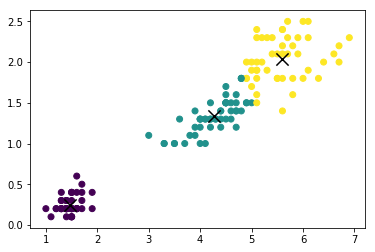

In [13]:
MAX_ITER = 15
document = zip(data.petal_length, data.petal_width)

best_accuracy = -1
best_centr = None
y_pred = []
best_label = []
best_k = 0

inicio = time()
for K in range(1, 30):
    y_pred, centroids = kmeans(data.petal_length, data.petal_width, k=K, iter_times=MAX_ITER, distFunction=euclidianDistance)

#     accuracy = metrics.adjusted_rand_score(y_true, y_pred)
    try:
        accuracy = metrics.v_measure_score(y_true, y_pred)
    except:
        print(y_pred)

    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_centr = centroids
        best_k = K
        best_label = y_pred

final = time()
    
print(f"Melhor valor para o K:   {best_k}\nObtendo uma acurácia de: {best_accuracy} (v_measure_score) \n\nTempo: {final-inicio}")
plotter(document, best_centr, best_label)

E claro, não poderia faltar um gráfico de relação entre K e acurácia resultante

Time: 0.11286115646362305

Gráfico: K por Acurácia


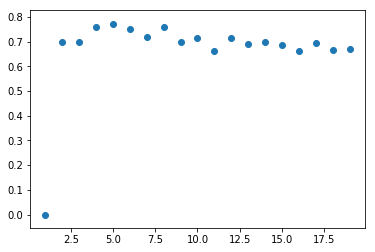

In [14]:
document = []

inicio = time()
for K in range(1, 20):
    y_pred, _ = kmeans(data.petal_length, data.petal_width, k=K, iter_times=MAX_ITER, distFunction=euclidianDistance)

#     accuracy = metrics.adjusted_rand_score(y_true, y_pred)
    try:
        accuracy = metrics.v_measure_score(y_true, y_pred)
    except:
        print(y_pred)

    document.append((K, accuracy))

final = time()

plotter2(document)

print(f"Time: {final-inicio}\n\nGráfico: K por Acurácia")